In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #pd.__version__ = 1.3.2
import matplotlib.patches as patches
from fiberassign.alg import proc1, proc2, proc3
from collections import Counter

In [2]:
"""
fiber configuration, all length units are [mm]
"""
alpha_length=5.2 #fiber positioner alpha arm length
beta_length=11.6 #fiber positioner beta arm length
col_cond=3.5 #beta arm width
thread_num=8 
max_loop=1e7 #maximun cases


fid_list=np.array([0,6,11,33,36,41,51,73,77,84,91,95,117,127,132,135,157,161,168]) #fudcial & guiding camera index
#73 -> 72  & 95 -> 96 ? fiducial changed ?
x,y=[],[]
xx=[]

d=16.8
n=8

adj_fib=[]


for i in range(2*n-1):
    if i<8 : 
        rownum=8+i
    else : 
        rownum=22-i
    for j in range(rownum):
            x.append((j-(rownum-1)/2)*d)
            y.append((n-1-i)*d*np.sqrt(3)/2)
x=np.delete(x,fid_list)
y=np.delete(y,fid_list)

for i in range(len(x)):
    r=pow(x-x[i],2)+pow(y-y[i],2)
    idx=np.where(r<4*16.8**2+0.01)
    adj_fib.append([item for item, count in Counter(idx[0]).items() if (count > 0) & (item != i)])
            

fiber_pos_3=pd.DataFrame({"x":x,"y":y,"fiber_num":np.arange(1,len(x)+1),"adj_fib_idx":adj_fib})

In [3]:
test1 = pd.read_csv('./test_object.csv')
### Include a dummy target (fix needed)
test1=test1.append(test1.iloc[0],ignore_index=True)
test1.iloc[0]['x']=150
test1.iloc[0]['y']=150
test1.iloc[0]['rank']=150 
###

#basic alg.
obj_3_assigned,fiber_pos_3,obj_3=proc1(test1,fiber_pos_3)
orig_assigned=obj_3_assigned.copy(deep=True)
group=proc2(obj_3,obj_3_assigned,fiber_pos_3,alpha_length,beta_length,col_cond)         
obj_3_assigned=proc3(orig_assigned,fiber_pos_3,group,obj_3,obj_3_assigned,thread_num,alpha_length,beta_length,max_loop,col_cond)

# Visualization

In [4]:
plt.rcParams['font.size']=25
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='STIXGeneral'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True

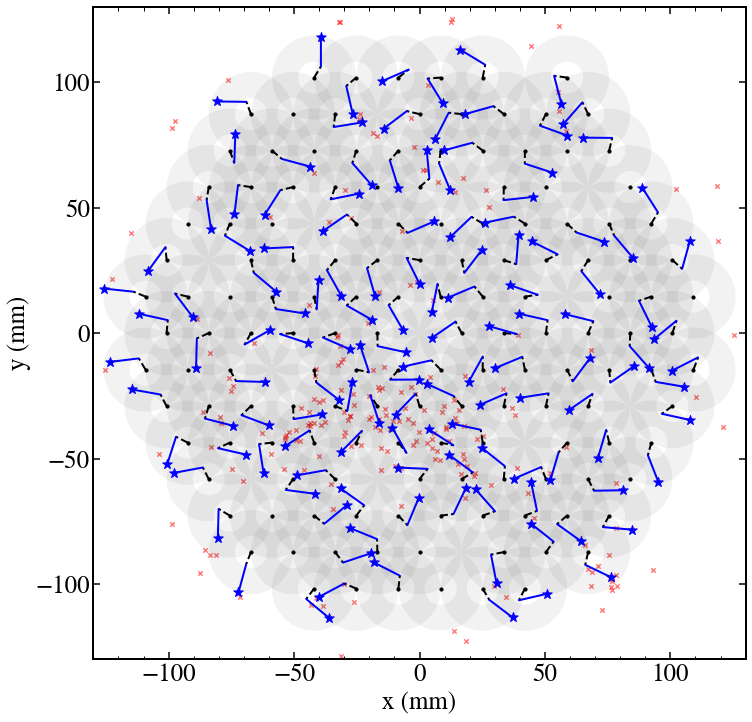

In [5]:
#configuration 
xx=np.array(obj_3_assigned['x']-obj_3_assigned['fiber_x'])
yy=np.array(obj_3_assigned['y']-obj_3_assigned['fiber_y'])
r=np.sqrt(xx*xx+yy*yy)
ang=np.arctan2(yy,xx)

beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi

plt.figure(figsize=(12,12))

for i in range(len(obj_3_assigned)):
    x=obj_3_assigned['fiber_x'][i]
    y=obj_3_assigned['fiber_y'][i]
    xx1=[x,x+np.cos(alpha[i])*alpha_length]
    xx2=[x+np.cos(alpha[i])*alpha_length,x+np.cos(alpha[i])*alpha_length+np.cos(beta[i]+alpha[i])*beta_length]
    yy1=[y,y+np.sin(alpha[i])*alpha_length]
    yy2=[y+np.sin(alpha[i])*alpha_length,y+np.sin(alpha[i])*alpha_length+np.sin(beta[i]+alpha[i])*beta_length] 

    plt.plot(xx1,yy1,'k--',lw=2,solid_capstyle='round')
    plt.plot(xx2,yy2,'b',lw=2,solid_capstyle='round')

plt.scatter(fiber_pos_3['x'],fiber_pos_3['y'],s=10,color='k')  
plt.scatter(test1['x'],test1['y'],marker='x',color='r',s=20,alpha=0.5)

theta=np.linspace(0,2*np.pi,100)

plt.scatter(obj_3_assigned['x'],obj_3_assigned['y'],marker='*',color='b',s=100,zorder=3)

for i in range(len(fiber_pos_3)):
    n, radii = 50, [6.4, 16.8]
    theta = np.linspace(0, 2*np.pi, n)
    xs = np.outer(radii, np.cos(theta))+fiber_pos_3['x'][i]
    ys = np.outer(radii, np.sin(theta))+fiber_pos_3['y'][i]

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    plt.fill(np.ravel(xs), np.ravel(ys),color='k',alpha=0.05,edgecolor=None)

plt.xlim(-130,130)
plt.ylim(-130,130)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()